In [1]:
%load_ext autoreload
%autoreload 2

In [131]:
import spyx
import spyx.nn as snn

# JAX imports
import os
import jax
from jax import numpy as jnp
import jmp # jax mixed-precision
import numpy as np

from jax_tqdm import scan_tqdm
from tqdm import tqdm

# implement our SNN in DeepMind's Haiku
import haiku as hk

# for surrogate loss training.
import optax

# rendering tools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from lif_light import LeakyLinear, RecurrentLIFLight

In [132]:
key = jax.random.PRNGKey(0)

In [133]:
def build(x, state1=None, state2=None):
    r1 = RecurrentLIFLight(
    1, tau=20, thr=0.62, dt=1, dtype=jnp.float32,
    dampening_factor=0.3, tau_adaptation=500, beta=0.07 * jnp.ones(1), n_refractory=3,
    w_rec_init=None, rec=True)
    r2 = RecurrentLIFLight(
    1, tau=20, thr=0.62, dt=1, dtype=jnp.float32,
    dampening_factor=0.3, tau_adaptation=500, beta=0.07 * jnp.zeros(1), n_refractory=3,
    w_rec_init=None, rec=True)
    # beta = 0 is the same as no adaptation


    if state1 is None:
        state1 = r1.initial_state(x.shape[0], n_rec=1)
    if state2 is None:
        state2 = r2.initial_state(x.shape[0], n_rec=1)

    return r1(x, state1), r2(x, state2)

rll = hk.without_apply_rng(hk.transform(build))
params = rll.init(rng=key, x=jnp.ones((1,1)))

decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)


In [134]:
params['RecurrentLIFLight']['w_rec'] = jnp.array([[1.0]])
params['RecurrentLIFLight_1']['w_rec'] = jnp.array([[1.0]])

In [135]:
params

{'RecurrentLIFLight': {'w_rec': Array([[1.]], dtype=float32)},
 'RecurrentLIFLight_1': {'w_rec': Array([[1.]], dtype=float32)}}

In [136]:
states = [None, None]

In [137]:
spikes = jax.random.uniform(key, (250, 1)) > 0.6#0.8

voltages = []
voltages2 = []
thresholds = []
thresholds2 = []
activations = []
activations2 = []
for i in range(len(spikes)):
    (out, state), (out2, state2) = rll.apply(params, jnp.ones((1, 1))*spikes[i], states[0], states[1])
    states = [state, state2]
    activations.append(out)
    voltages.append(state.s[..., 0])
    thresholds.append(state.s[..., 1])
    activations2.append(out2)
    voltages2.append(state2.s[..., 0])
    thresholds2.append(state2.s[..., 1])

voltages = jnp.stack(voltages, axis=0)
voltages = voltages.reshape(-1)

voltages2 = jnp.stack(voltages2, axis=0)
voltages2 = voltages2.reshape(-1)

activations = jnp.stack(activations, axis=0)
activations = activations.reshape(-1)

activations2 = jnp.stack(activations2, axis=0)
activations2 = activations2.reshape(-1)

thresholds = jnp.stack(thresholds, axis=0)
thresholds = thresholds.reshape(-1)

thresholds2 = jnp.stack(thresholds2, axis=0)
thresholds2 = thresholds2.reshape(-1)

decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin (1, 1)
decay b 0.998002
decay b 0.998002
iin (1, 1)
iin

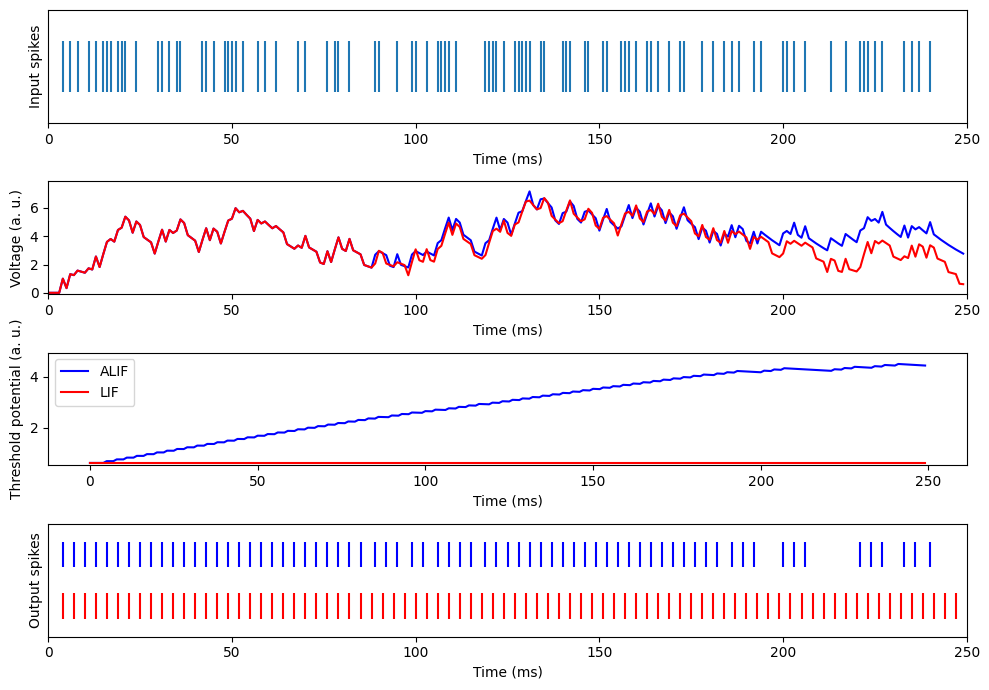

In [143]:
import matplotlib.pyplot as plt

n_row = 4
plt.figure(figsize=(10, 7))

plt.subplot(n_row, 1, 1)
plt.eventplot(np.where(spikes)[0], linelengths=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Input spikes")
plt.yticks([])
plt.xlim(0, len(spikes))

plt.subplot(n_row, 1, 2)
plt.plot(voltages, label='ALIF', color='b')
plt.plot(voltages2, label='LIF', color='r')
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (a. u.)")
plt.ylim(jnp.min(voltages) - 0.1, jnp.max(voltages) * 1.1)
plt.xlim(0, len(spikes))

plt.subplot(n_row, 1, 3)
ath = 0.07 * jnp.ones(1) * thresholds + 0.62
ath2 = 0.07 * jnp.zeros(1) * thresholds2 + 0.62
plt.plot(ath, label='ALIF', color='b')
plt.plot(ath2, label='LIF', color='r')
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Threshold potential (a. u.)")
plt.ylim(jnp.min(ath) - 0.1, jnp.max(ath) * 1.1)

plt.subplot(n_row, 1, 4)
plt.eventplot(np.where(activations)[0], linelengths=0.5, label='ALIF', colors='b')
plt.eventplot(np.where(activations2)[0], linelengths=0.5, label='LIF', colors='r', lineoffsets=0)
# plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Output spikes")
plt.yticks([])
plt.xlim(0, len(spikes))

plt.xlim(0, len(spikes))

plt.tight_layout()
plt.show()

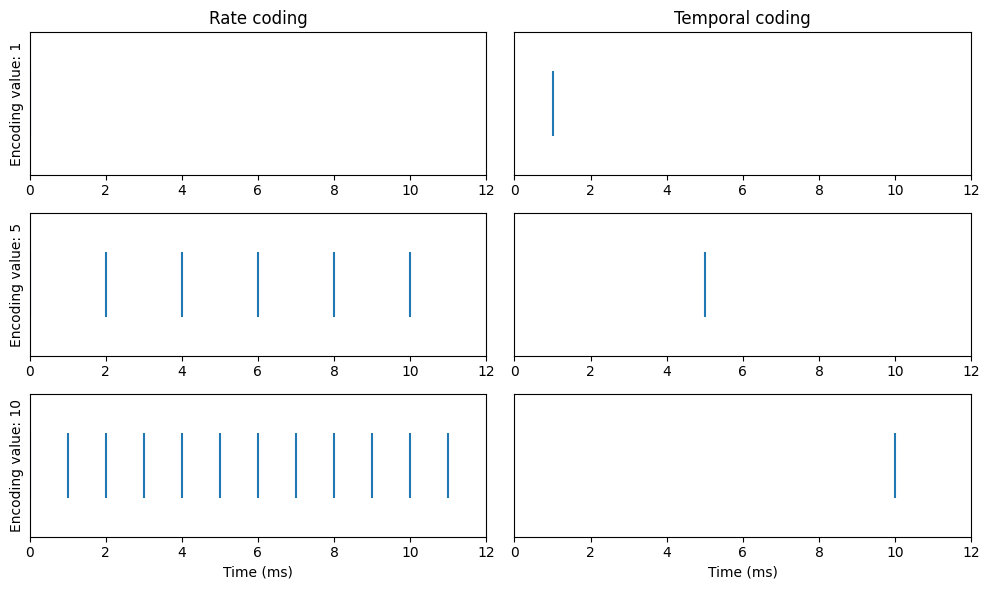

In [156]:
import matplotlib.pyplot as plt

values = [1, 5, 10]

plt.subplots(len(values), 2, figsize=(10, 2*len(values)))

plt.subplot(len(values), 2, 1)
plt.title("Rate coding")

plt.subplot(len(values), 2, 2)
plt.title("Temporal coding")

plt.subplot(len(values), 2, len(values)*2-1)
plt.xlabel("Time (ms)")

plt.subplot(len(values), 2, len(values)*2)
plt.xlabel("Time (ms)")

for i, value in enumerate(values):
    plt.subplot(len(values), 2, 2*i+1)
    length = 12
    rate_coding = jnp.zeros(length)
    rate_coding = rate_coding.at[::length//value].set(1)
    plt.eventplot(np.where(rate_coding)[0], linelengths=0.5)
    plt.xlim(0, length)
    plt.yticks([])
    plt.ylabel(f"Encoding value: {value}")

    plt.subplot(len(values), 2, 2*i+2)
    temporal_coding = jnp.zeros(length)
    temporal_coding=  temporal_coding.at[value].set(1)
    plt.eventplot(np.where(temporal_coding)[0], linelengths=0.5)
    plt.xlim(0, length)
    plt.yticks([])

plt.tight_layout()
